In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


In [2]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 254.24787541400002 seconds


In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [9]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


## Test Train Split

In [10]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [11]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


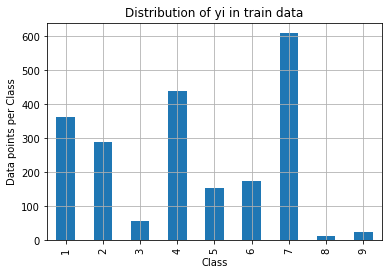

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


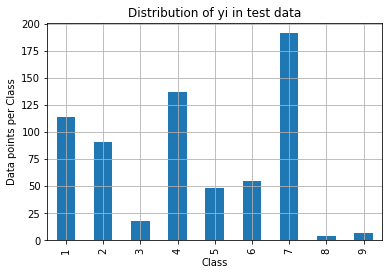

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


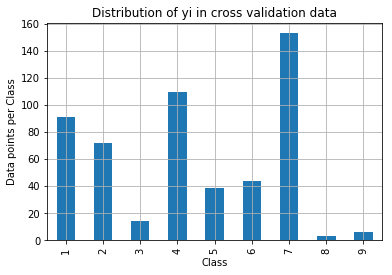

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [14]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


In [52]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## Random Model

Log loss on Cross Validation Data using Random Model 2.5682238670753508
Log loss on Test Data using Random Model 2.5626395832792936
-------------------- Confusion matrix --------------------


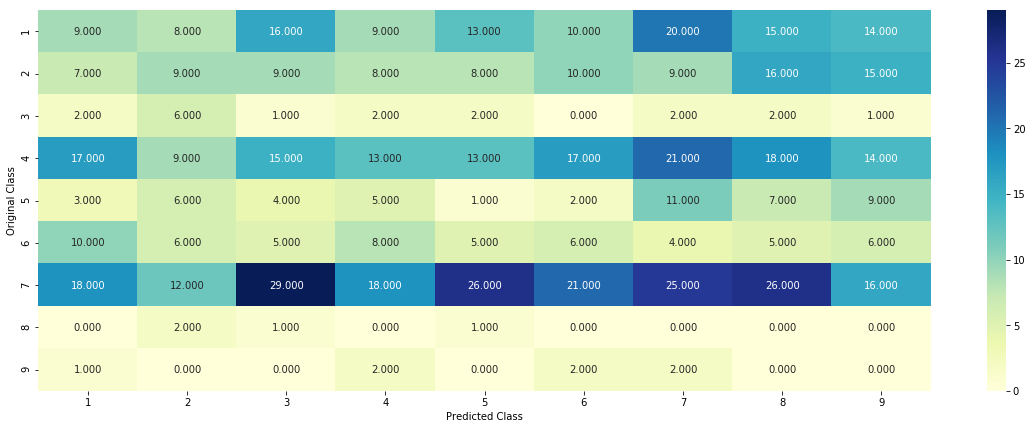

-------------------- Precision matrix (Columm Sum=1) --------------------


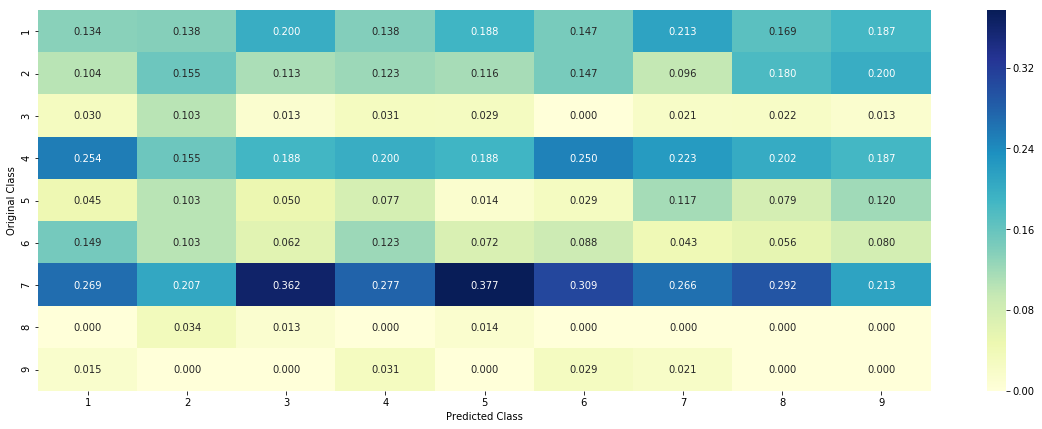

-------------------- Recall matrix (Row sum=1) --------------------


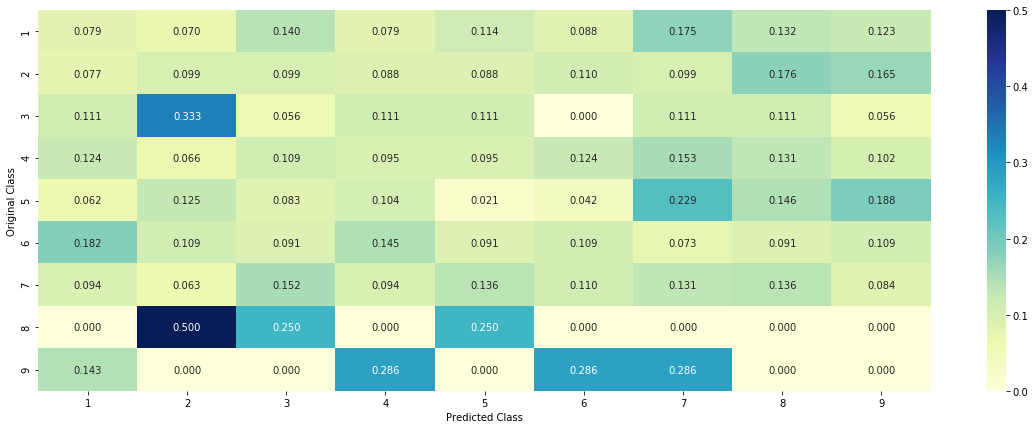

In [16]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

## Univeriate Analysis


In [13]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

### Gene

In [14]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [15]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [16]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [17]:
train_df['Gene'].head()

993       TSC1
3284       RET
279     NKX2-1
936     PDGFRB
308      H3F3A
Name: Gene, dtype: object

In [18]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl2',
 'atm',
 'atrx',
 'aurka',
 'axin1',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikb

In [19]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 231)


### Variance

In [20]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [21]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [22]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [23]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1962)


### Text

In [24]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [25]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

## Task 1 and Task 2

In [26]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3  , max_features = 1000)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [27]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [28]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [29]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [30]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [31]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

## Stacking Features for Task 1 and Task 2

In [32]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [33]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [34]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [35]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [36]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 3193)
(number of data points * number of features) in test data =  (665, 3193)
(number of data points * number of features) in cross validation data = (532, 3193)


In [37]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## Models for Task 1 and Task 2

### Naive Bayes

for alpha = 1e-05
Log Loss : 1.234175481304672
for alpha = 0.0001
Log Loss : 1.2325104182957276
for alpha = 0.001
Log Loss : 1.2307518780076145
for alpha = 0.1
Log Loss : 1.2516420839941085
for alpha = 1
Log Loss : 1.3362764655799413
for alpha = 10
Log Loss : 1.5338769675569262
for alpha = 100
Log Loss : 1.4845246066037388
for alpha = 1000
Log Loss : 1.4704801460634724


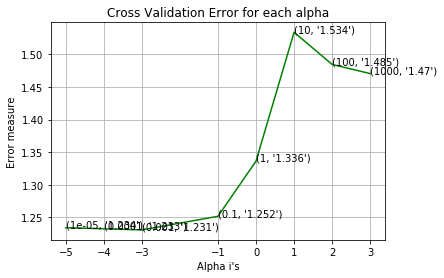

For values of best alpha =  0.001 The train log loss is: 0.5054699005198862
For values of best alpha =  0.001 The cross validation log loss is: 1.2307518780076145
For values of best alpha =  0.001 The test log loss is: 1.2118281132894633


In [42]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.2307518780076145
Number of missclassified point : 0.40789473684210525
-------------------- Confusion matrix --------------------


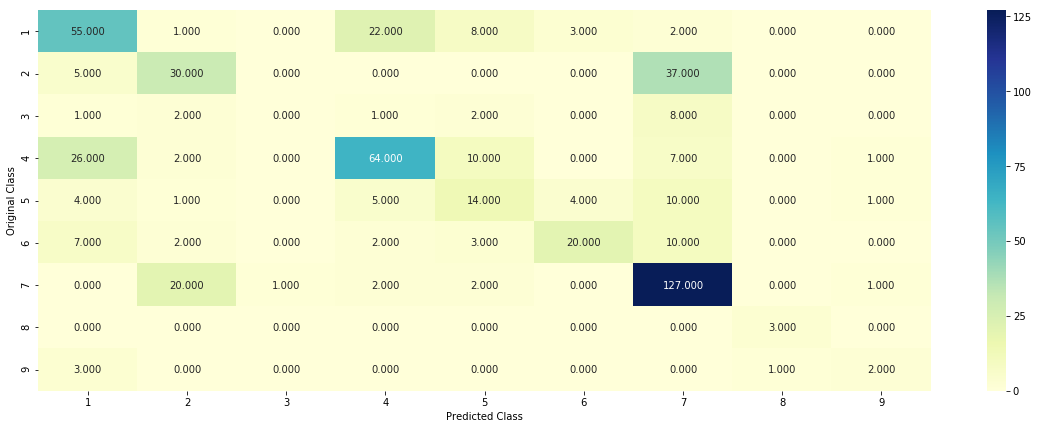

-------------------- Precision matrix (Columm Sum=1) --------------------


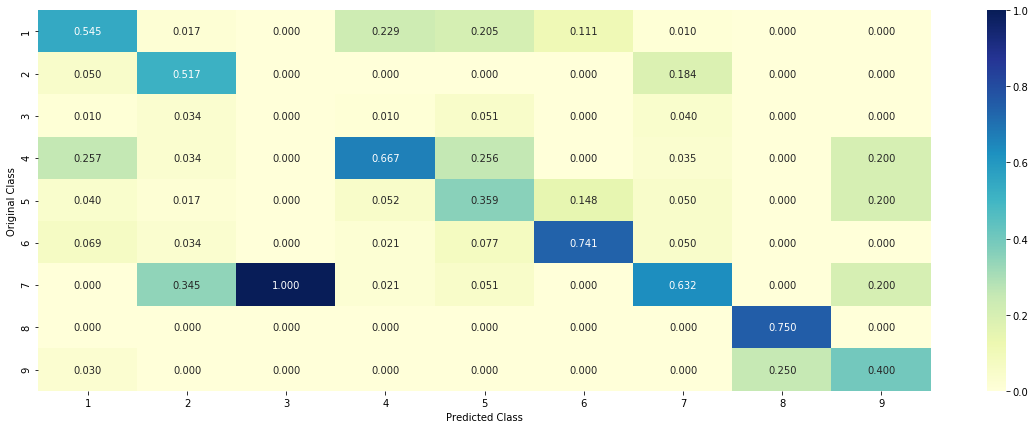

-------------------- Recall matrix (Row sum=1) --------------------


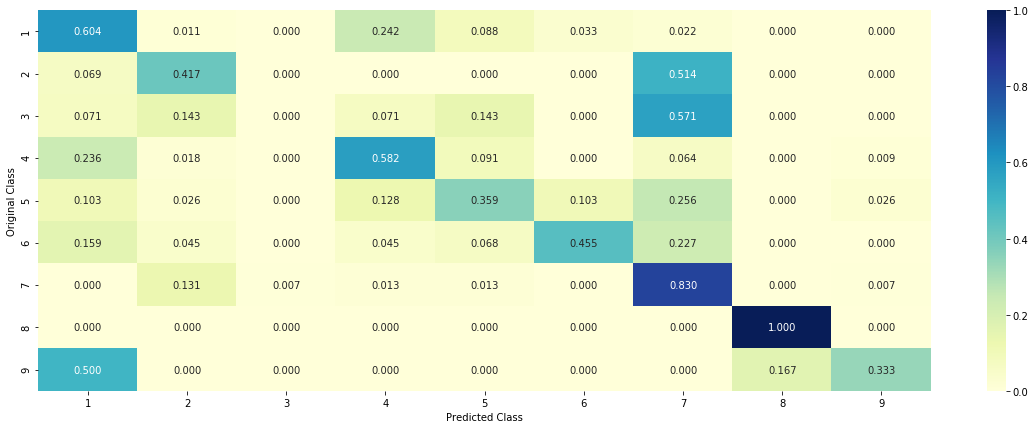

In [43]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [44]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.276  0.0385 0.0095 0.528  0.0281 0.03   0.0848 0.0029 0.0023]]
Actual Class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [45]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0564 0.0451 0.0097 0.0591 0.0285 0.0307 0.7653 0.003  0.0023]]
Actual Class : 7
--------------------------------------------------
22 Text feature [04] present in test data point [True]
24 Text feature [059] present in test data point [True]
28 Text feature [12] present in test data point [True]
47 Text feature [016] present in test data point [True]
70 Text feature [116] present in test data point [True]
97 Text feature [124] present in test data point [True]
Out of the top  100  features  6 are present in query point


### KNN

for alpha = 5
Log Loss : 1.1056528641243168
for alpha = 11
Log Loss : 1.103624228970529
for alpha = 15
Log Loss : 1.0853742448607222
for alpha = 21
Log Loss : 1.0833020566021219
for alpha = 31
Log Loss : 1.0849681914935085
for alpha = 41
Log Loss : 1.091744510318548
for alpha = 51
Log Loss : 1.0969050510161233
for alpha = 99
Log Loss : 1.135348999791154


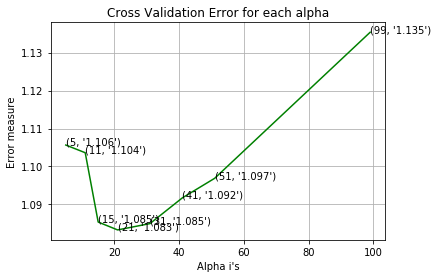

For values of best alpha =  21 The train log loss is: 0.7308713777277042
For values of best alpha =  21 The cross validation log loss is: 1.0833020566021219
For values of best alpha =  21 The test log loss is: 1.064580553723534


In [46]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.0833020566021219
Number of mis-classified points : 0.39097744360902253
-------------------- Confusion matrix --------------------


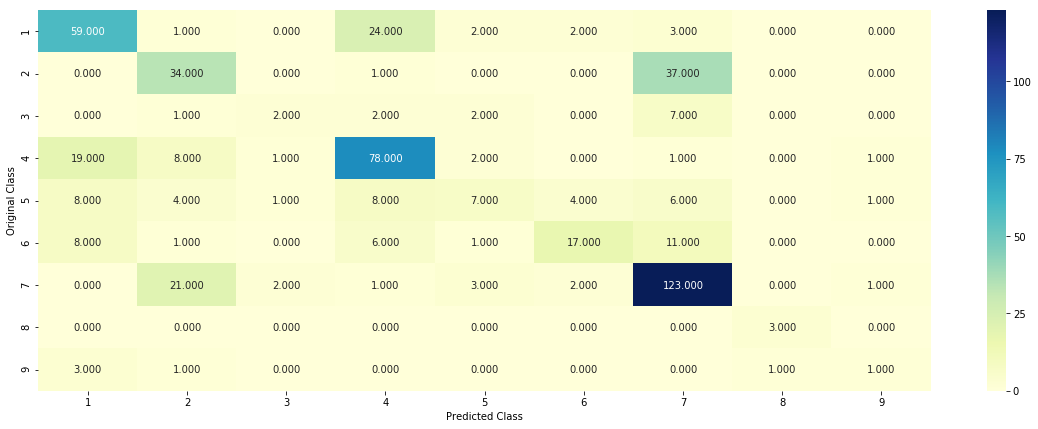

-------------------- Precision matrix (Columm Sum=1) --------------------


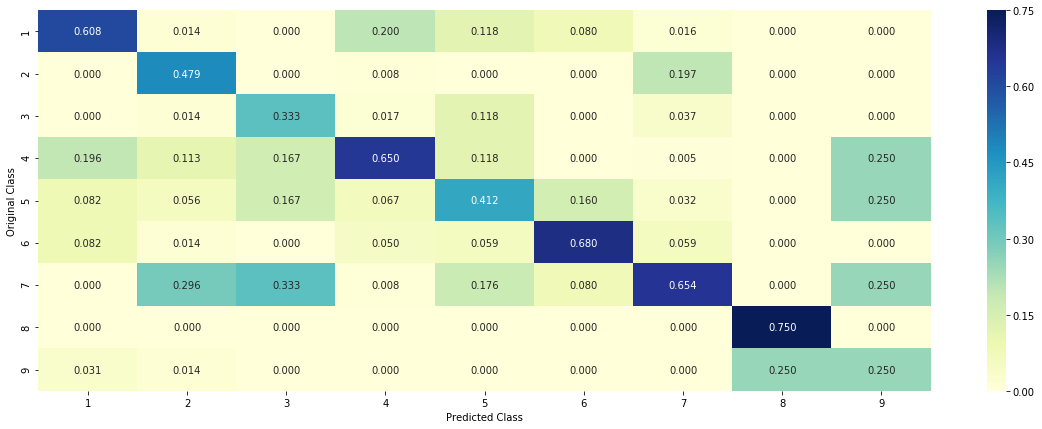

-------------------- Recall matrix (Row sum=1) --------------------


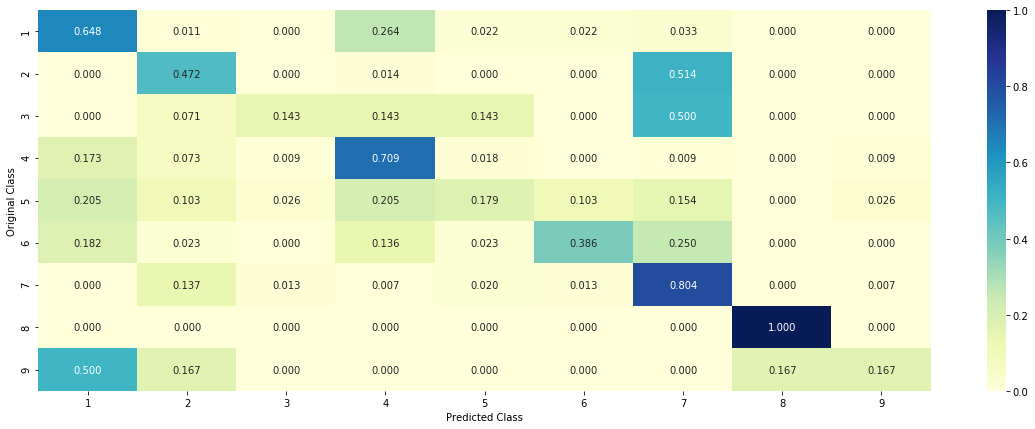

In [47]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [48]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
The  21  nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 1 4 1 1 1 1 1 1 4 1 1 4 1 4 1]
Fequency of nearest points : Counter({1: 17, 4: 4})


In [49]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
the k value for knn is 21 and the nearest neighbours of the test points belongs to classes [7 7 7 2 2 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
Fequency of nearest points : Counter({7: 19, 2: 2})


### Logistic Regression

#### Class Balancing

for alpha = 1e-06
Log Loss : 1.2054124821327425
for alpha = 1e-05
Log Loss : 1.0995946075495058
for alpha = 0.0001
Log Loss : 1.0504528591067457
for alpha = 0.001
Log Loss : 1.0633769229263532
for alpha = 0.01
Log Loss : 1.2361340512970338
for alpha = 0.1
Log Loss : 1.6311480700119412
for alpha = 1
Log Loss : 1.7576925569280826
for alpha = 10
Log Loss : 1.7727902225812369
for alpha = 100
Log Loss : 1.7746035023337539


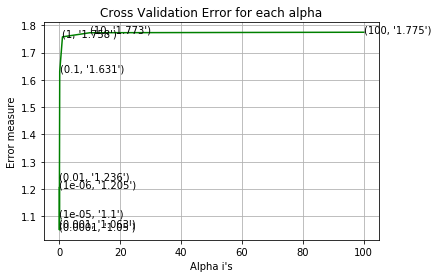

For values of best alpha =  0.0001 The train log loss is: 0.4319908676021416
For values of best alpha =  0.0001 The cross validation log loss is: 1.0504528591067457
For values of best alpha =  0.0001 The test log loss is: 1.044618029758128


In [50]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0504528591067457
Number of mis-classified points : 0.36466165413533835
-------------------- Confusion matrix --------------------


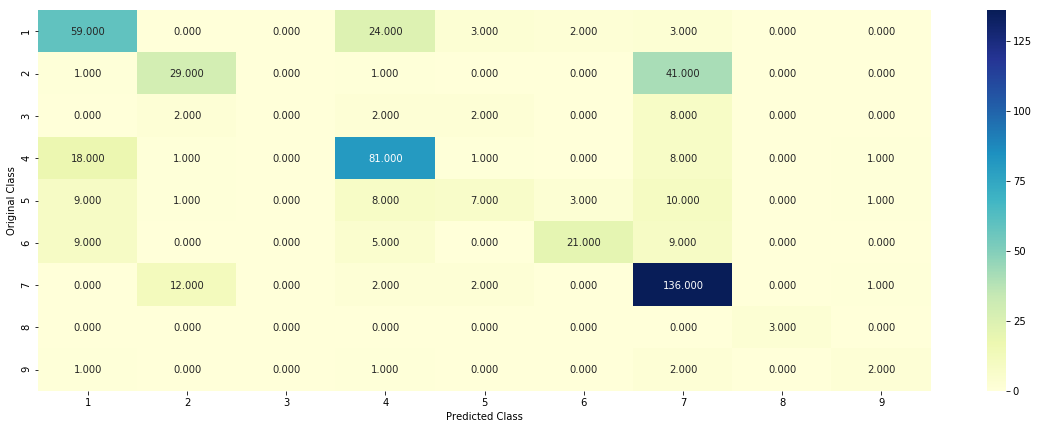

-------------------- Precision matrix (Columm Sum=1) --------------------


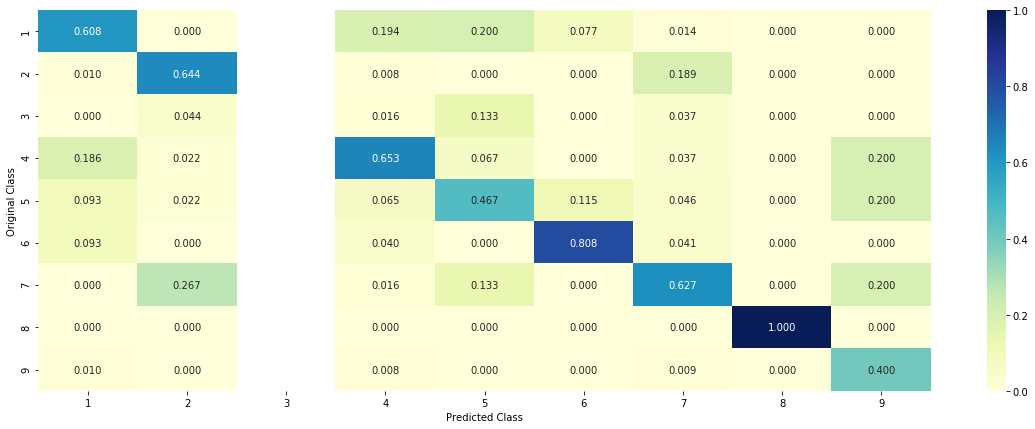

-------------------- Recall matrix (Row sum=1) --------------------


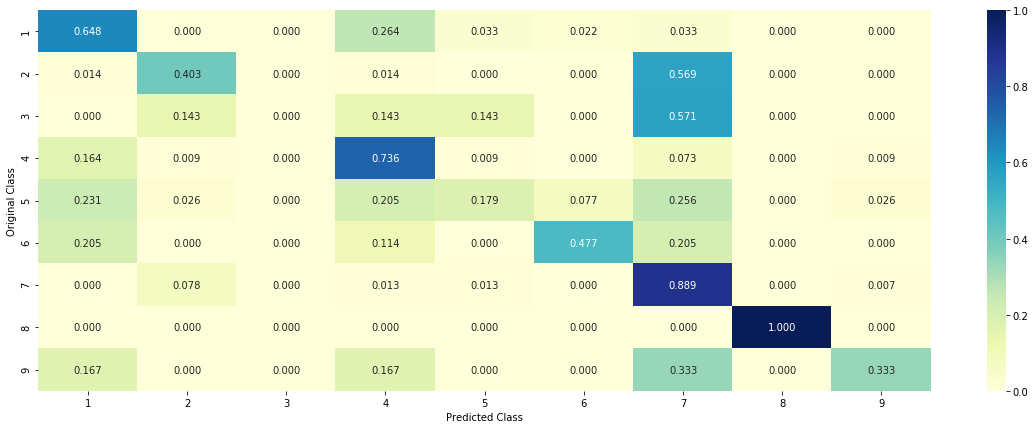

In [51]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [52]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [53]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[7.642e-01 6.000e-04 2.000e-04 2.296e-01 9.000e-04 5.000e-04 1.900e-03
  2.100e-03 1.000e-04]]
Actual Class : 1
--------------------------------------------------
268 Text feature [061] present in test data point [True]
335 Text feature [1000] present in test data point [True]
342 Text feature [122] present in test data point [True]
357 Text feature [1080] present in test data point [True]
399 Text feature [11] present in test data point [True]
416 Text feature [11c] present in test data point [True]
429 Text feature [09] present in test data point [True]
438 Text feature [07] present in test data point [True]
457 Text feature [05] present in test data point [True]
Out of the top  500  features  9 are present in query point


In [54]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.780e-02 2.167e-01 4.000e-04 9.000e-03 7.500e-03 1.260e-02 7.313e-01
  4.400e-03 3.000e-04]]
Actual Class : 7
--------------------------------------------------
17 Text feature [04] present in test data point [True]
80 Text feature [059] present in test data point [True]
291 Text feature [12] present in test data point [True]
300 Text feature [1037] present in test data point [True]
357 Text feature [107] present in test data point [True]
Out of the top  500  features  5 are present in query point


#### Without Class balancing

for alpha = 1e-06
Log Loss : 1.2313943815412036
for alpha = 1e-05
Log Loss : 1.1504417349527178
for alpha = 0.0001
Log Loss : 1.0921665597725978
for alpha = 0.001
Log Loss : 1.1565748552793225
for alpha = 0.01
Log Loss : 1.3941683025585838
for alpha = 0.1
Log Loss : 1.7638998872537126
for alpha = 1
Log Loss : 1.8412127323990917


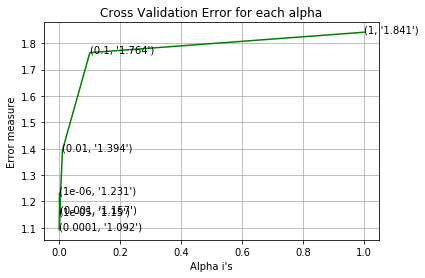

For values of best alpha =  0.0001 The train log loss is: 0.4254338801884324
For values of best alpha =  0.0001 The cross validation log loss is: 1.0921665597725978
For values of best alpha =  0.0001 The test log loss is: 1.0662900072596788


In [55]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0921665597725978
Number of mis-classified points : 0.37406015037593987
-------------------- Confusion matrix --------------------


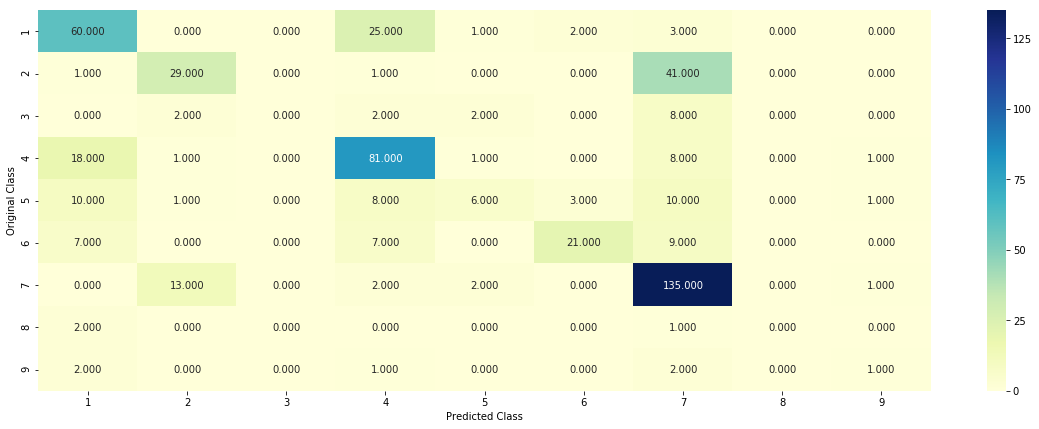

-------------------- Precision matrix (Columm Sum=1) --------------------


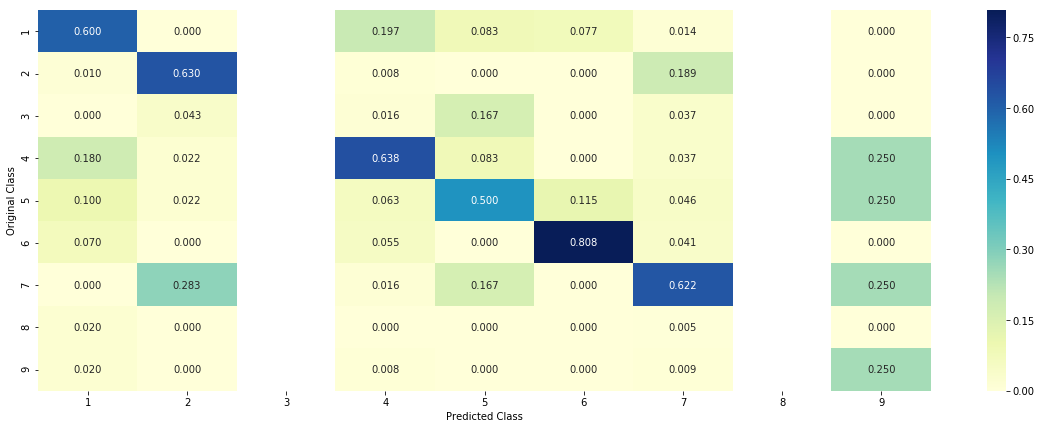

-------------------- Recall matrix (Row sum=1) --------------------


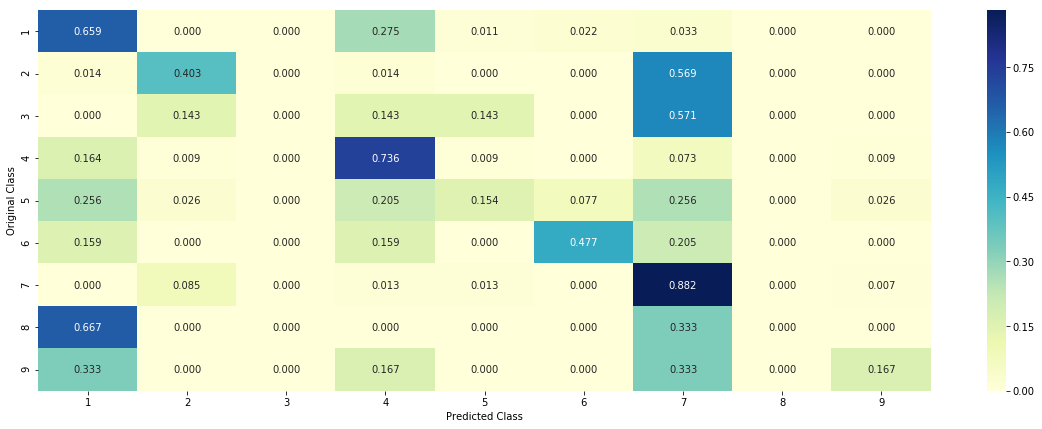

In [56]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [57]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[7.542e-01 6.000e-04 1.000e-04 2.387e-01 8.000e-04 6.000e-04 3.100e-03
  1.800e-03 0.000e+00]]
Actual Class : 1
--------------------------------------------------
268 Text feature [061] present in test data point [True]
318 Text feature [1000] present in test data point [True]
346 Text feature [122] present in test data point [True]
350 Text feature [1080] present in test data point [True]
392 Text feature [11] present in test data point [True]
410 Text feature [11c] present in test data point [True]
429 Text feature [09] present in test data point [True]
440 Text feature [07] present in test data point [True]
446 Text feature [05] present in test data point [True]
Out of the top  500  features  9 are present in query point


In [58]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.700e-02 2.079e-01 2.000e-04 9.000e-03 6.000e-03 1.200e-02 7.442e-01
  3.600e-03 1.000e-04]]
Actual Class : 7
--------------------------------------------------
30 Text feature [04] present in test data point [True]
171 Text feature [059] present in test data point [True]
394 Text feature [12] present in test data point [True]
398 Text feature [1037] present in test data point [True]
399 Text feature [107] present in test data point [True]
Out of the top  500  features  5 are present in query point


### Linear Support Vector Machines

for C = 1e-05
Log Loss : 1.1443480515250624
for C = 0.0001
Log Loss : 1.0839640040489313
for C = 0.001
Log Loss : 1.0966881065516048
for C = 0.01
Log Loss : 1.368996376470014
for C = 0.1
Log Loss : 1.6409025060668958
for C = 1
Log Loss : 1.7751300564856036
for C = 10
Log Loss : 1.775125183444996
for C = 100
Log Loss : 1.7751251212595163


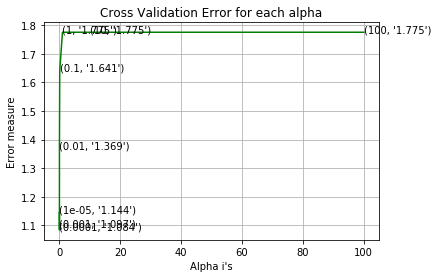

For values of best alpha =  0.0001 The train log loss is: 0.3844568098510124
For values of best alpha =  0.0001 The cross validation log loss is: 1.0839640040489313
For values of best alpha =  0.0001 The test log loss is: 1.073623099142414


In [59]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0839640040489313
Number of mis-classified points : 0.3684210526315789
-------------------- Confusion matrix --------------------


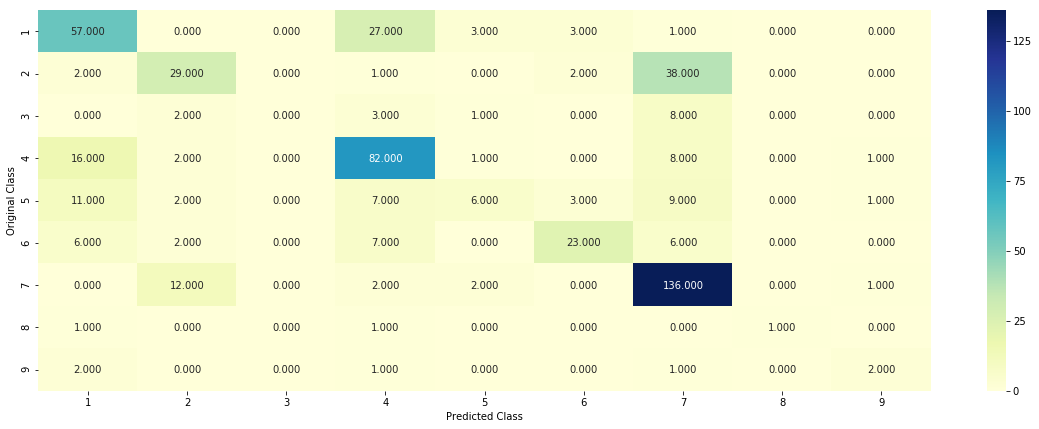

-------------------- Precision matrix (Columm Sum=1) --------------------


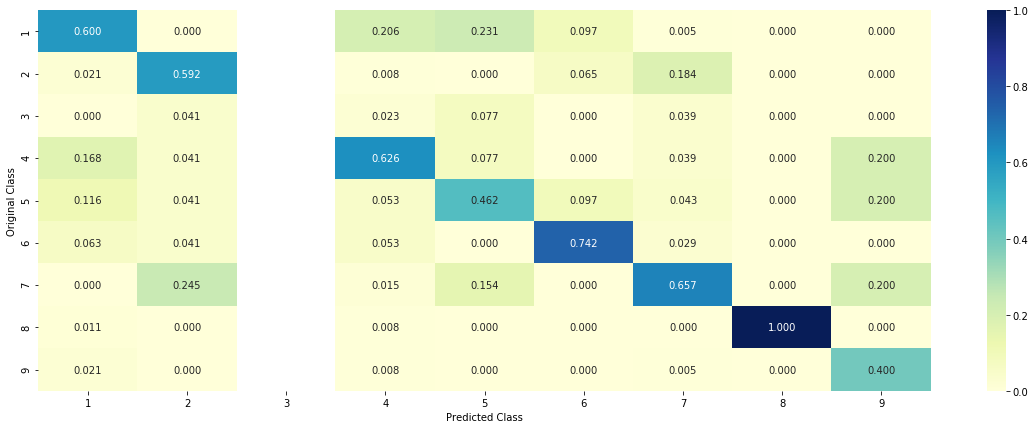

-------------------- Recall matrix (Row sum=1) --------------------


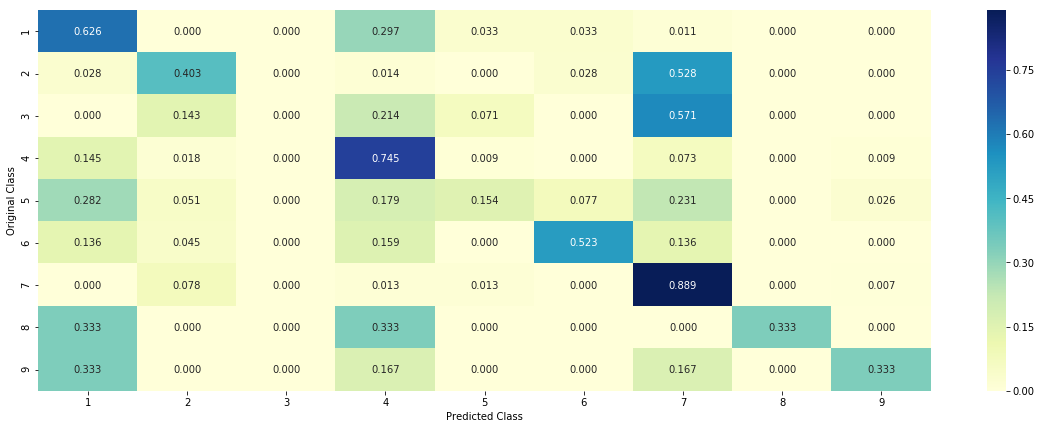

In [60]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------


# clf = SVC(C=alpha[best_alpha],kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [61]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[7.242e-01 1.700e-03 1.000e-03 2.513e-01 7.000e-04 1.300e-03 1.810e-02
  1.500e-03 3.000e-04]]
Actual Class : 1
--------------------------------------------------
293 Text feature [061] present in test data point [True]
302 Text feature [1000] present in test data point [True]
317 Text feature [11c] present in test data point [True]
325 Text feature [122] present in test data point [True]
330 Text feature [1080] present in test data point [True]
348 Text feature [129] present in test data point [True]
351 Text feature [09] present in test data point [True]
409 Text feature [11] present in test data point [True]
449 Text feature [05] present in test data point [True]
Out of the top  500  features  9 are present in query point


In [62]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[6.170e-02 2.344e-01 1.200e-03 2.500e-02 1.420e-02 2.260e-02 6.390e-01
  1.200e-03 5.000e-04]]
Actual Class : 7
--------------------------------------------------
51 Text feature [04] present in test data point [True]
266 Text feature [109] present in test data point [True]
450 Text feature [059] present in test data point [True]
462 Text feature [12] present in test data point [True]
465 Text feature [107] present in test data point [True]
Out of the top  500  features  5 are present in query point


### Random Forest Classifier

#### Hyper paramter tuning (With One hot Encoding)

In [63]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2531243672118642
for n_estimators = 100 and max depth =  10
Log Loss : 1.2702302430655508
for n_estimators = 200 and max depth =  5
Log Loss : 1.2443852217576221
for n_estimators = 200 and max depth =  10
Log Loss : 1.2681651550469275
for n_estimators = 500 and max depth =  5
Log Loss : 1.2368446614473756
for n_estimators = 500 and max depth =  10
Log Loss : 1.2602034549392245
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2339524527543857
for n_estimators = 1000 and max depth =  10
Log Loss : 1.2596047748339885
for n_estimators = 2000 and max depth =  5
Log Loss : 1.233606430992424
for n_estimators = 2000 and max depth =  10
Log Loss : 1.25686933051152
For values of best estimator =  2000 The train log loss is: 0.8612857776185032
For values of best estimator =  2000 The cross validation log loss is: 1.233606430992424
For values of best estimator =  2000 The test log loss is: 1.1900523722318201


Log loss : 1.233606430992424
Number of mis-classified points : 0.45864661654135336
-------------------- Confusion matrix --------------------


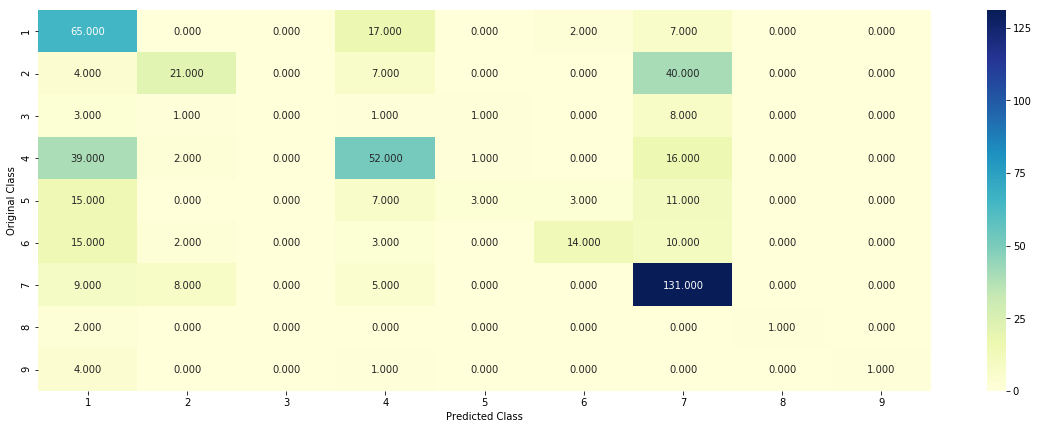

-------------------- Precision matrix (Columm Sum=1) --------------------


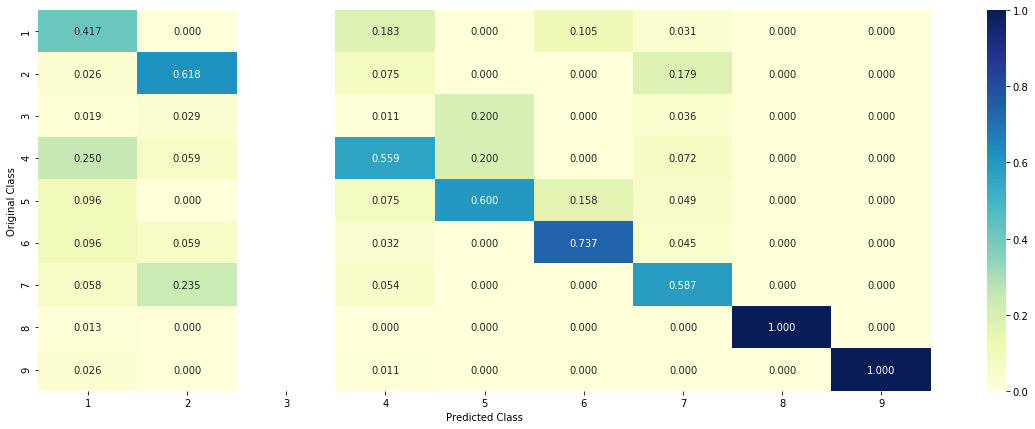

-------------------- Recall matrix (Row sum=1) --------------------


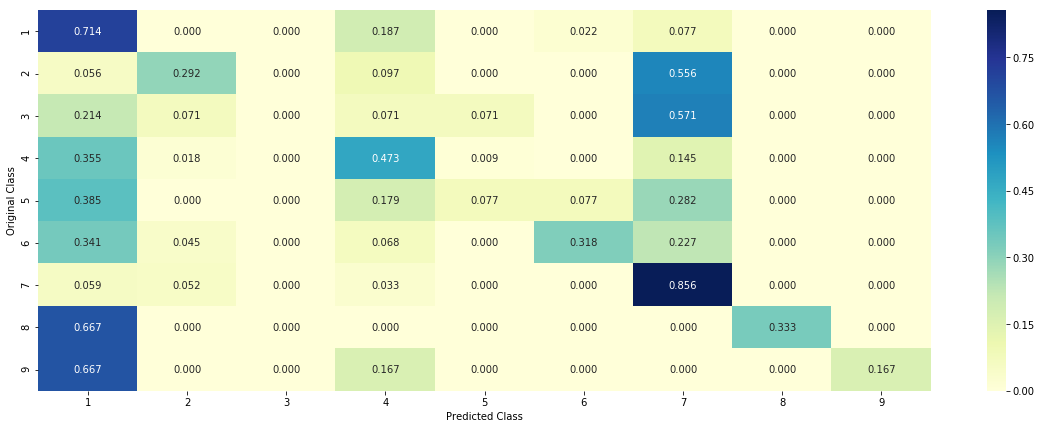

In [64]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [65]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5499 0.0323 0.0121 0.2062 0.071  0.0524 0.0558 0.0084 0.0119]]
Actual Class : 1
--------------------------------------------------
14 Text feature [11] present in test data point [True]
19 Text feature [12] present in test data point [True]
66 Text feature [06] present in test data point [True]
70 Text feature [04] present in test data point [True]
Out of the top  100  features  4 are present in query point


In [66]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1096 0.1596 0.0166 0.0657 0.0533 0.0555 0.52   0.0129 0.0068]]
Actuall Class : 7
--------------------------------------------------
14 Text feature [11] present in test data point [True]
18 Text feature [127] present in test data point [True]
19 Text feature [12] present in test data point [True]
23 Text feature [116] present in test data point [True]
39 Text feature [001] present in test data point [True]
70 Text feature [04] present in test data point [True]
74 Text feature [113] present in test data point [True]
96 Text feature [059] present in test data point [True]
Out of the top  100  features  8 are present in query point


#### Hyper paramter tuning (With Response Coding)

In [67]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
'''
fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/4)],max_depth[int(i%4)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.3287430228372274
for n_estimators = 10 and max depth =  3
Log Loss : 1.7046646856003516
for n_estimators = 10 and max depth =  5
Log Loss : 1.5075139876736112
for n_estimators = 10 and max depth =  10
Log Loss : 2.074063815746536
for n_estimators = 50 and max depth =  2
Log Loss : 1.8650210027815395
for n_estimators = 50 and max depth =  3
Log Loss : 1.587637133715814
for n_estimators = 50 and max depth =  5
Log Loss : 1.5358644485757793
for n_estimators = 50 and max depth =  10
Log Loss : 1.9437119413869632
for n_estimators = 100 and max depth =  2
Log Loss : 1.6956594164527707
for n_estimators = 100 and max depth =  3
Log Loss : 1.6492806768197361
for n_estimators = 100 and max depth =  5
Log Loss : 1.3876313593272718
for n_estimators = 100 and max depth =  10
Log Loss : 1.773799568403502
for n_estimators = 200 and max depth =  2
Log Loss : 1.7489235582654765
for n_estimators = 200 and max depth =  3
Log Loss : 1.6714105815371334


Log loss : 1.387631359327275
Number of mis-classified points : 0.5394736842105263
-------------------- Confusion matrix --------------------


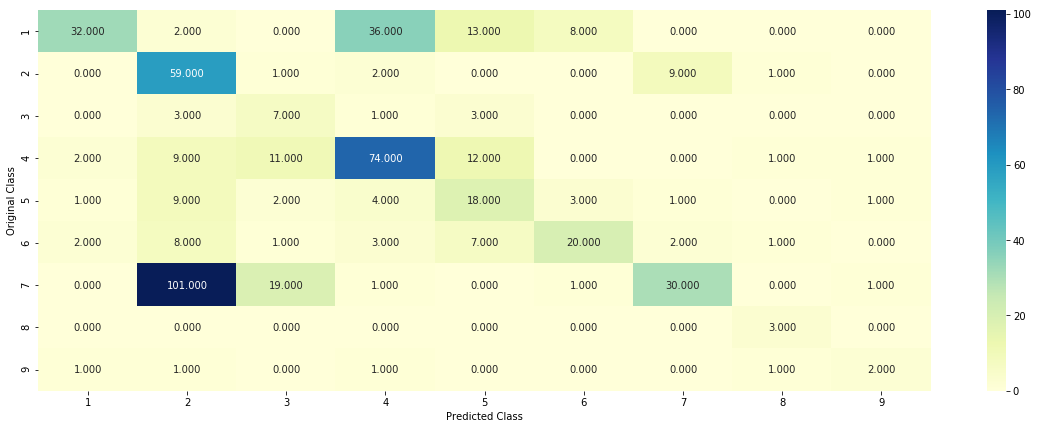

-------------------- Precision matrix (Columm Sum=1) --------------------


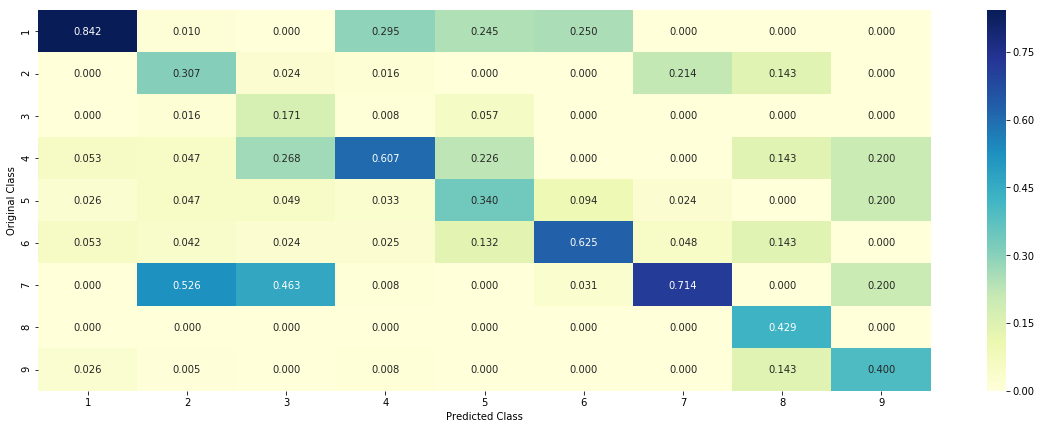

-------------------- Recall matrix (Row sum=1) --------------------


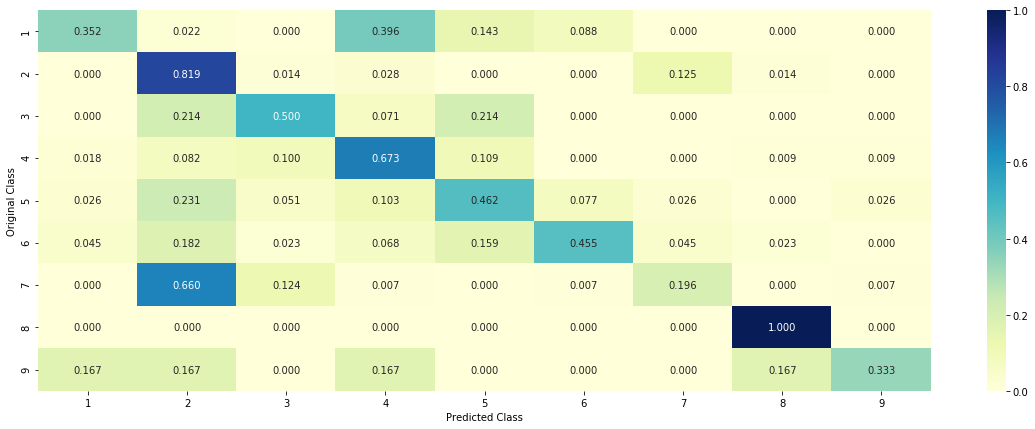

In [68]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [69]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.4452 0.002  0.0013 0.5404 0.0011 0.0059 0.0008 0.0018 0.0015]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature


In [70]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.0019 0.0046 0.002  0.003  0.0014 0.0032 0.9797 0.0023 0.0019]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature


## Stack the models

In [71]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------


# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.06
Support vector machines : Log Loss: 1.78
Naive Bayes : Log Loss: 1.23
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.177
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.030
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.503
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.206
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.481
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.017


Log loss (train) on the stacking classifier : 0.5250338804158265
Log loss (CV) on the stacking classifier : 1.2058730892709058
Log loss (test) on the stacking classifier : 1.1763847569858252
Number of missclassified point : 0.3819548872180451
-------------------- Confusion matrix --------------------


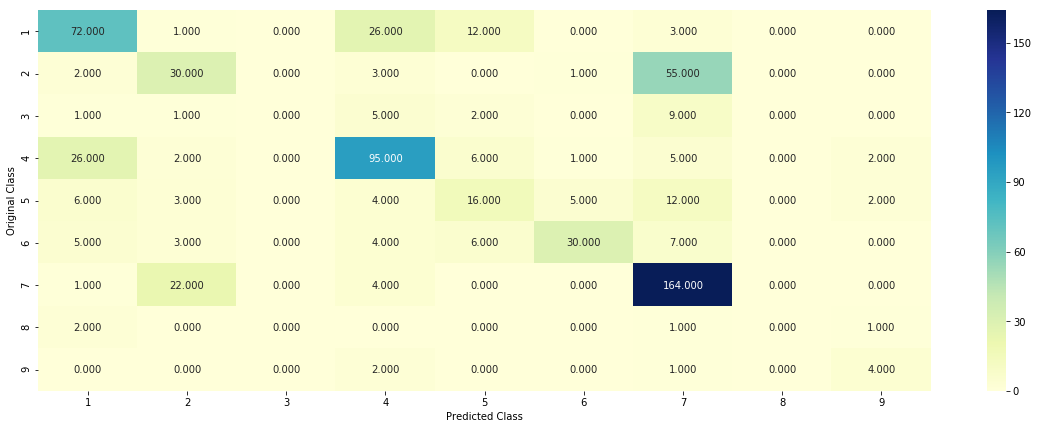

-------------------- Precision matrix (Columm Sum=1) --------------------


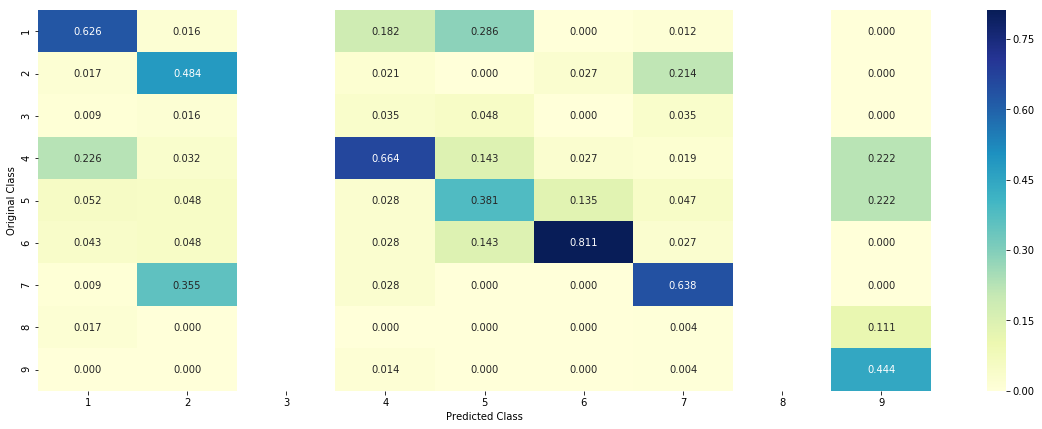

-------------------- Recall matrix (Row sum=1) --------------------


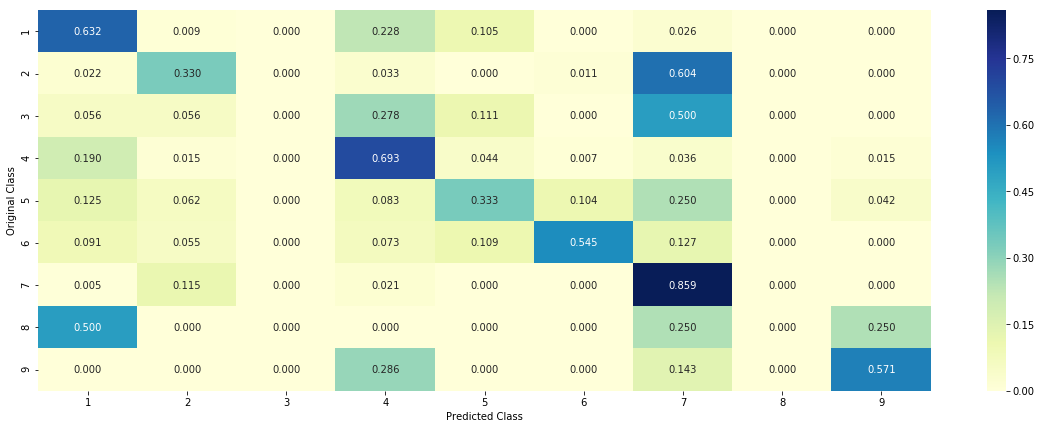

In [72]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

Log loss (train) on the VotingClassifier : 0.8169568464053505
Log loss (CV) on the VotingClassifier : 1.2160376372544275
Log loss (test) on the VotingClassifier : 1.2006830392091619
Number of missclassified point : 0.37293233082706767
-------------------- Confusion matrix --------------------


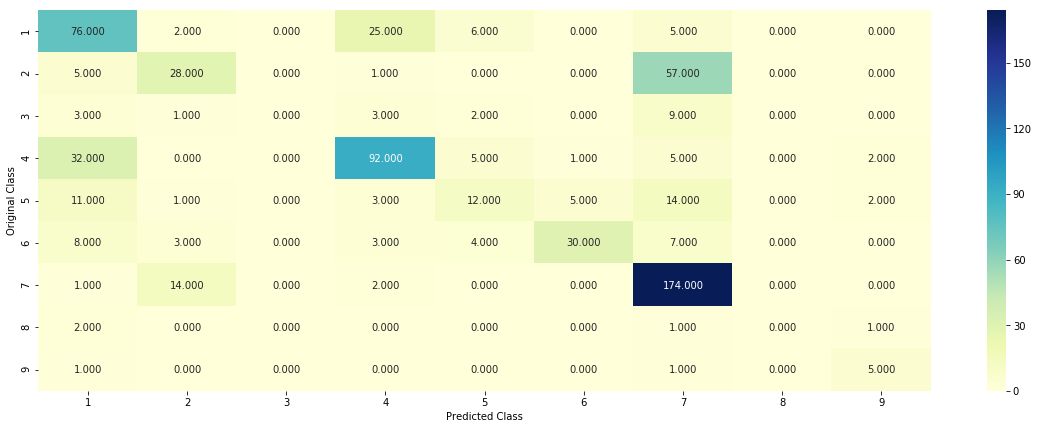

-------------------- Precision matrix (Columm Sum=1) --------------------


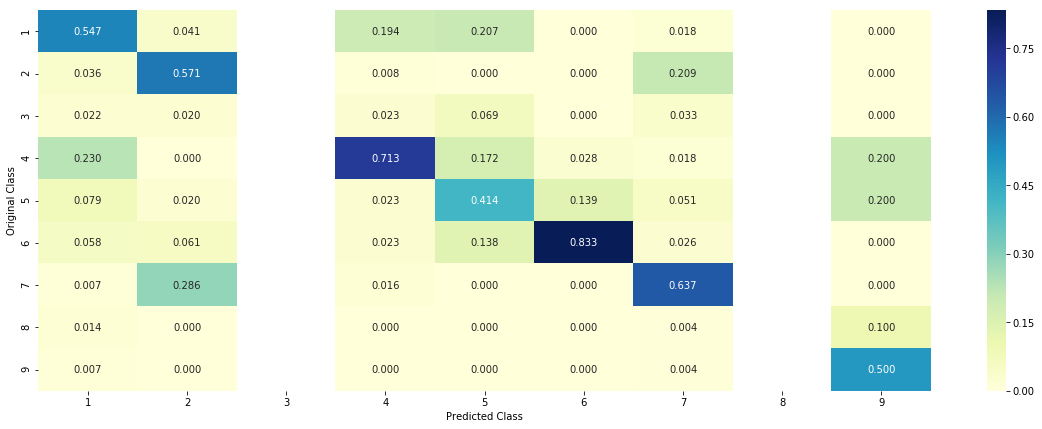

-------------------- Recall matrix (Row sum=1) --------------------


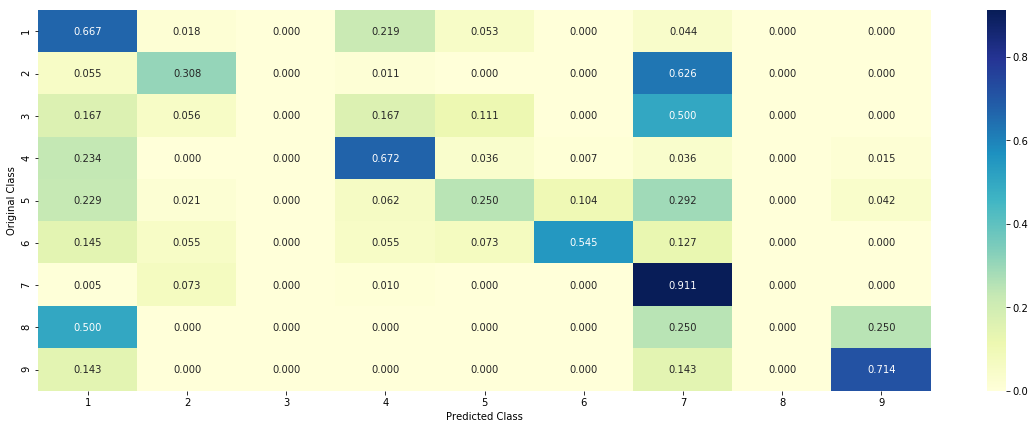

In [73]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

## Task 3

In [97]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3  ,ngram_range=(1, 2))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 789713


In [98]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [99]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

for alpha = 1e-06
Log Loss : 1.5832078997387673
for alpha = 1e-05
Log Loss : 1.5523777127563372
for alpha = 0.0001
Log Loss : 1.4763871842929956
for alpha = 0.001
Log Loss : 1.2112421620425216
for alpha = 0.01
Log Loss : 1.1971986723122443
for alpha = 0.1
Log Loss : 1.2514692477720835
for alpha = 1
Log Loss : 1.36043521188043
for alpha = 10
Log Loss : 1.4338266883377488
for alpha = 100
Log Loss : 1.4508057832214438


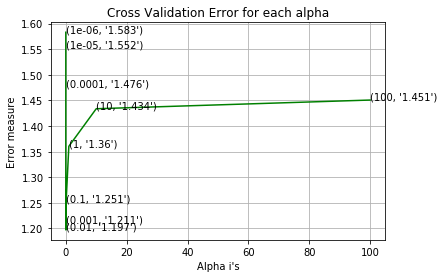

For values of best alpha =  0.01 The train log loss is: 0.696898959035767
For values of best alpha =  0.01 The cross validation log loss is: 1.1971986723122443
For values of best alpha =  0.01 The test log loss is: 1.1622383780893861


In [100]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1971986723122443
Number of mis-classified points : 0.40789473684210525
-------------------- Confusion matrix --------------------


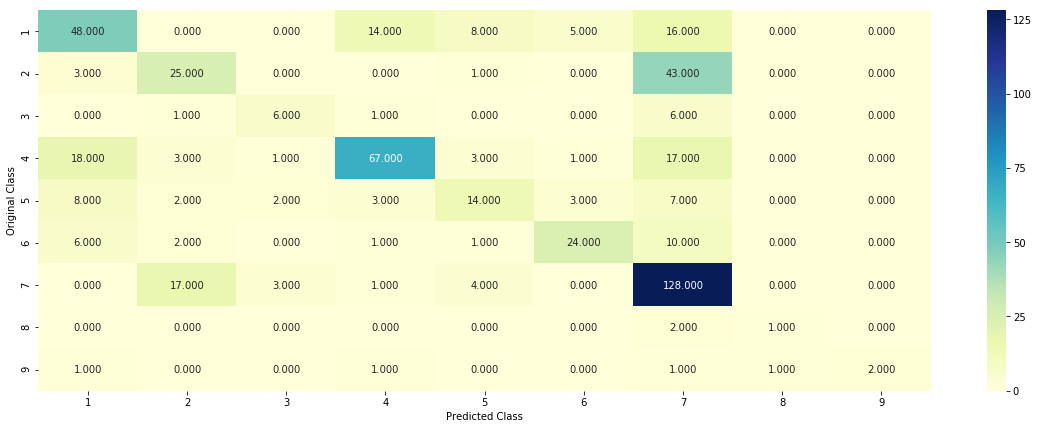

-------------------- Precision matrix (Columm Sum=1) --------------------


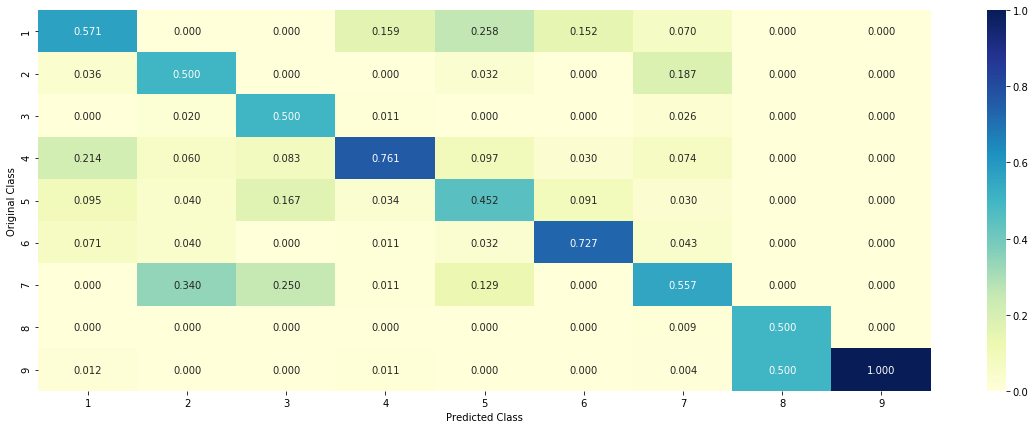

-------------------- Recall matrix (Row sum=1) --------------------


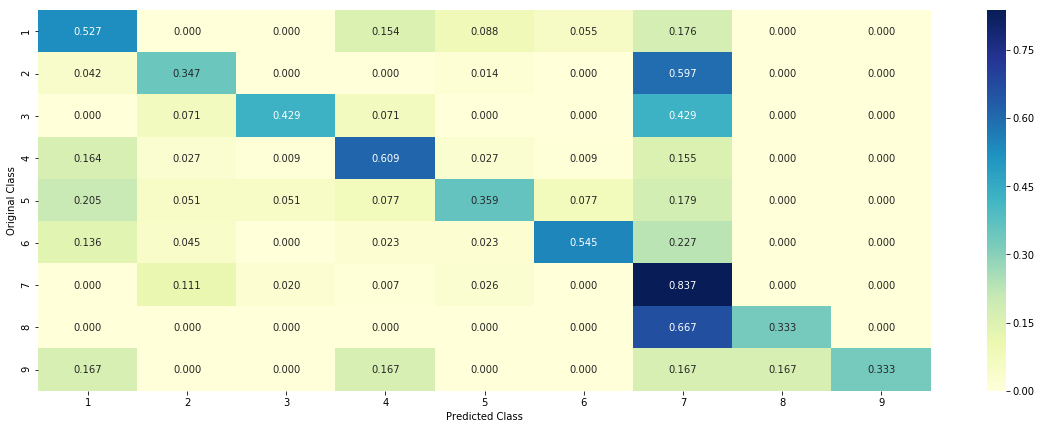

In [101]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [107]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [109]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3  ,ngram_range=(1, 2))
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [111]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1344 0.1549 0.0171 0.1709 0.0639 0.0488 0.3957 0.0067 0.0075]]
Actual Class : 1
--------------------------------------------------
115 Text feature [elicited] present in test data point [True]
463 Text feature [constitutive] present in test data point [True]
Out of the top  500  features  2 are present in query point


In [112]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[5.000e-04 1.263e-01 1.000e-04 2.000e-04 6.000e-04 0.000e+00 8.646e-01
  7.700e-03 1.000e-04]]
Actual Class : 7
--------------------------------------------------
168 Text feature [sealing] present in test data point [True]
232 Text feature [rac] present in test data point [True]
447 Text feature [rab] present in test data point [True]
463 Text feature [constitutive] present in test data point [True]
Out of the top  500  features  4 are present in query point


## Task 4

In [38]:
train_df.head()

,ID,Gene,Variation,Class,TEXT
993,993,TSC1,L117P,4,tuberous sclerosis complex tsc autosomal domin...
3284,3284,RET,KIF5B-RET_Fusion,7,considerable proportion ladcs common histologi...
279,279,NKX2-1,IGH-NKX2_Fusion,2,40 pediatric cases underlying oncogenic rearra...
936,936,PDGFRB,WDR48-PDGFRB_Fusion,2,acquired constitutive activation protein tyros...
308,308,H3F3A,G35V,8,dna entry exit points nucleosome core regulate...


In [39]:
train_df.loc[:, 'Text_count']  = train_df["TEXT"].apply(lambda x: len(x.split()))
cv_df.loc[:, 'Text_count']  = cv_df["TEXT"].apply(lambda x: len(x.split()))
test_df.loc[:, 'Text_count']  = test_df["TEXT"].apply(lambda x: len(x.split()))


In [40]:
train_df.head()

,ID,Gene,Variation,Class,TEXT,Text_count
993,993,TSC1,L117P,4,tuberous sclerosis complex tsc autosomal domin...,2839
3284,3284,RET,KIF5B-RET_Fusion,7,considerable proportion ladcs common histologi...,999
279,279,NKX2-1,IGH-NKX2_Fusion,2,40 pediatric cases underlying oncogenic rearra...,5196
936,936,PDGFRB,WDR48-PDGFRB_Fusion,2,acquired constitutive activation protein tyros...,1629
308,308,H3F3A,G35V,8,dna entry exit points nucleosome core regulate...,11914


In [159]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3, max_features = 10000)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 10000


In [160]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [161]:
import scipy
train_text_count= scipy.sparse.csr_matrix(train_df["Text_count"])
train_text_count = normalize(train_text_count, axis = 0)
cv_text_count= scipy.sparse.csr_matrix(cv_df["Text_count"])
cv_text_count = normalize(cv_text_count, axis = 0)
test_text_count= scipy.sparse.csr_matrix(test_df["Text_count"])
test_text_count = normalize(test_text_count, axis = 0)

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding,train_text_count.T )).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding, test_text_count.T)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding, cv_text_count.T)).tocsr()
cv_y = np.array(list(cv_df['Class']))

train_text_count= np.array(train_df["Text_count"])
train_text_count = normalize(train_text_count[:, None], axis = 0)
cv_text_count= np.array(cv_df["Text_count"])
cv_text_count = normalize(cv_text_count[:, None], axis = 0)
test_text_count= np.array(test_df["Text_count"])
test_text_count = normalize(test_text_count[:, None], axis = 0)

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding,train_text_count))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding,test_text_count))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding,cv_text_count))

In [162]:
train_x_responseCoding.shape

(2124, 28)

for alpha = 1e-06
Log Loss : 1.125504078538516
for alpha = 1e-05
Log Loss : 1.1239248512207627
for alpha = 0.0001
Log Loss : 1.0213836086319916
for alpha = 0.001
Log Loss : 0.9946200280326147
for alpha = 0.01
Log Loss : 1.0789229463916397
for alpha = 0.1
Log Loss : 1.2701666106975573
for alpha = 1
Log Loss : 1.6930849740262792
for alpha = 10
Log Loss : 1.720717814927168
for alpha = 100
Log Loss : 1.7248942978647146


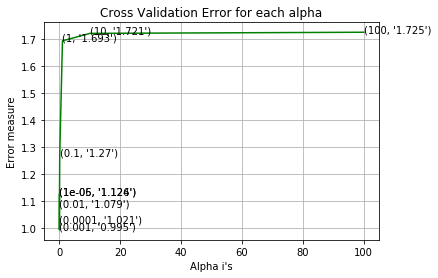

For values of best alpha =  0.001 The train log loss is: 0.5315555959126662
For values of best alpha =  0.001 The cross validation log loss is: 0.9946200280326147
For values of best alpha =  0.001 The test log loss is: 0.977960055362255


In [163]:

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.9946200280326147
Number of mis-classified points : 0.36466165413533835
-------------------- Confusion matrix --------------------


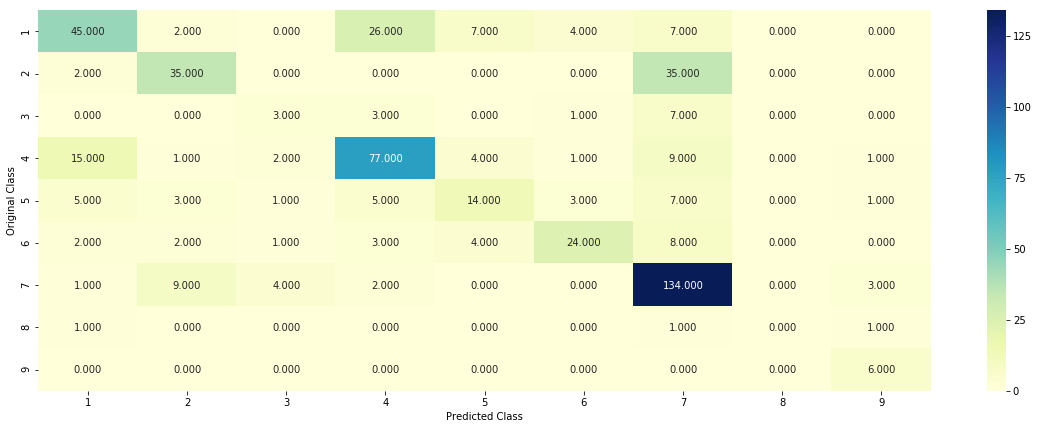

-------------------- Precision matrix (Columm Sum=1) --------------------


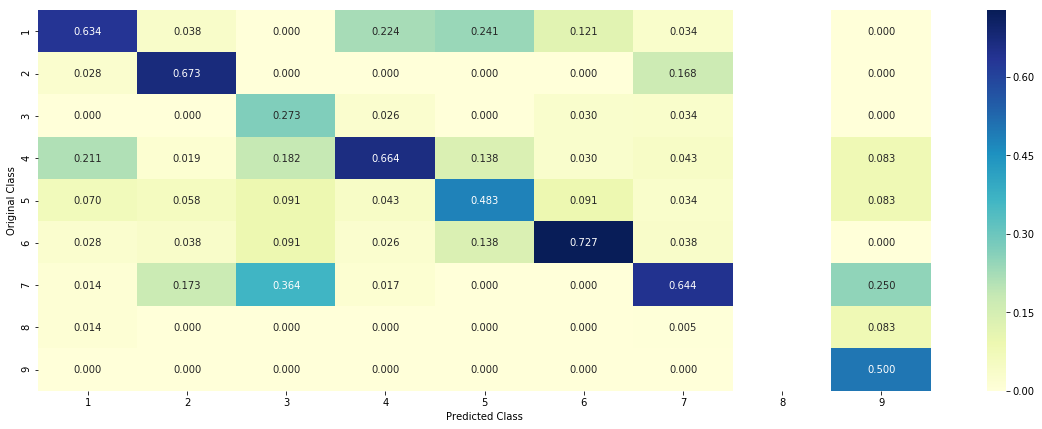

-------------------- Recall matrix (Row sum=1) --------------------


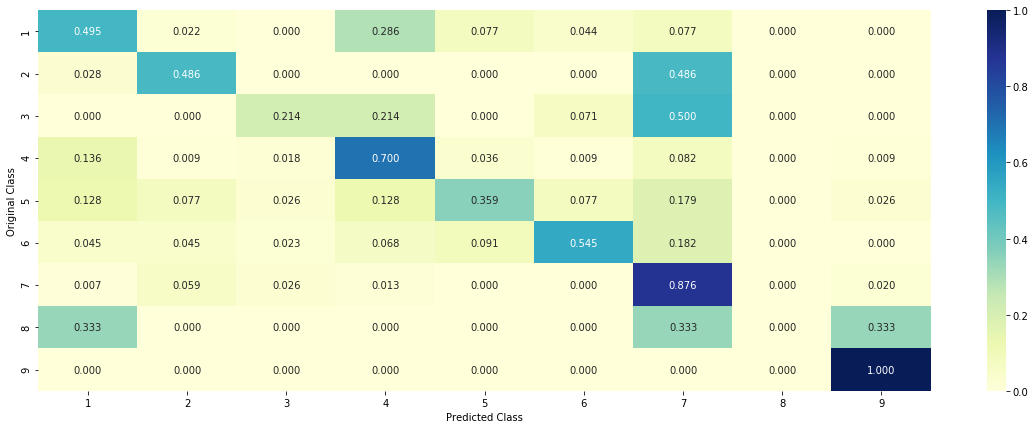

In [164]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [165]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [166]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[4.500e-03 4.900e-03 1.830e-02 9.573e-01 7.600e-03 3.400e-03 1.600e-03
  1.400e-03 9.000e-04]]
Actual Class : 4
--------------------------------------------------
50 Text feature [associated] present in test data point [True]
201 Text feature [activation] present in test data point [True]
229 Text feature [21] present in test data point [True]
254 Text feature [asd] present in test data point [True]
315 Text feature [a126d] present in test data point [True]
317 Text feature [adjusted] present in test data point [True]
390 Text feature [13] present in test data point [True]
462 Text feature [24] present in test data point [True]
474 Text feature [124] present in test data point [True]
Out of the top  500  features  9 are present in query point


In [167]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6167 0.0047 0.0009 0.3565 0.0076 0.0101 0.0011 0.001  0.0013]]
Actual Class : 1
--------------------------------------------------
44 Text feature [50] present in test data point [True]
114 Text feature [affinities] present in test data point [True]
149 Text feature [28] present in test data point [True]
Out of the top  500  features  3 are present in query point


In [180]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Vectorizer", "Hyper Parameter", "Test Logloss", 'Train Logloss']

x.add_row(["Naive Bayes", "TFIDF", 0.001, 1.21,0.5])
x.add_row(["KNN", "TFIDF", 21, 1.06,0.73])
x.add_row(["Logistic Regression(Balance)", "TFIDF", 0.0001, 1.04,0.43])
x.add_row(["Logistic Regression(Imbalance)", "TFIDF", 0.0001, 1.06,0.42])
x.add_row(["SVM", "TFIDF", 0.0001, 1.07,0.38])
x.add_row(["Random Forest", "TFIDF", 2000, 1.19,0.86])
x.add_row(["Random Forest", "Response Coding", 100, 1.33,0.05])
x.add_row(["Stack Model", "TFIDF", 0.1, 1.17,0.52])
x.add_row(["Logistic Regression", "BOW(nGram)", 0.01, 1.16,0.69])
x.add_row(["Logistic Regression", "Task 4", 0.001, 0.97,0.53])


print(x)

+--------------------------------+-----------------+-----------------+--------------+---------------+
|             Model              |    Vectorizer   | Hyper Parameter | Test Logloss | Train Logloss |
+--------------------------------+-----------------+-----------------+--------------+---------------+
|          Naive Bayes           |      TFIDF      |      0.001      |     1.21     |      0.5      |
|              KNN               |      TFIDF      |        21       |     1.06     |      0.73     |
|  Logistic Regression(Balance)  |      TFIDF      |      0.0001     |     1.04     |      0.43     |
| Logistic Regression(Imbalance) |      TFIDF      |      0.0001     |     1.06     |      0.42     |
|              SVM               |      TFIDF      |      0.0001     |     1.07     |      0.38     |
|         Random Forest          |      TFIDF      |       2000      |     1.19     |      0.86     |
|         Random Forest          | Response Coding |       100       |     1.33   